# Task Exception Prediction - Machine Learning Model

## Project Overview

This notebook presents a complete machine learning pipeline for predicting task exceptions in transportation operations. The goal is to build a binary classification model that can identify when an exception (RED) will occur versus normal operations (GOOD).

### Objective
Train a model to predict exceptions with **precision > 50%**, prioritizing precision over recall as per case requirements.

### Key Requirements
- **Target Variable**: `Exception_output` (RED = exception occurred, GOOD = no exception)
- **Train/Test Split**: 95% training, 5% test (stratified)
- **Primary Metric**: Precision > 50%
- **Model**: XGBoost with precision-focused hyperparameters

### Model Selection: XGBoost vs Random Forest

**Why XGBoost was chosen:**

1. **Superior Regularization Control**: XGBoost offers fine-grained regularization through `reg_alpha` (L1) and `reg_lambda` (L2) parameters, which is crucial for achieving high precision by reducing overfitting and false positives.

2. **Early Stopping**: Built-in early stopping mechanism prevents overfitting by monitoring validation performance, essential when prioritizing precision over recall.

3. **Class Imbalance Handling**: Better support for `scale_pos_weight` parameter, allowing precise control over how the model handles imbalanced classes (GOOD vs RED).

4. **Hyperparameter Tuning for Precision**: More granular control over tree depth (`max_depth`), learning rate, and minimum child weight, enabling optimization specifically for precision-focused objectives.

5. **Gradient Boosting Architecture**: Sequential learning allows the model to focus on difficult cases and minimize false positives, which directly improves precision.

6. **Computational Efficiency**: Faster training and prediction times, especially important for iterative hyperparameter tuning required to meet the precision > 50% requirement.

**Why Random Forest was not chosen:**

1. **Limited Regularization Options**: Random Forest has fewer regularization mechanisms compared to XGBoost, making it harder to fine-tune for precision optimization.

2. **No Early Stopping**: Lacks built-in early stopping, requiring manual tuning of `n_estimators` and potentially leading to overfitting or underfitting.

3. **Less Control Over Precision**: The bagging approach averages predictions from multiple trees, which can dilute the model's ability to minimize false positives compared to gradient boosting.

4. **Class Imbalance Handling**: While Random Forest supports class weights, XGBoost's `scale_pos_weight` provides more intuitive and effective control for imbalanced datasets.

5. **Hyperparameter Sensitivity**: Random Forest's performance is more sensitive to `max_depth` and `min_samples_split`, but offers less flexibility for precision-focused tuning compared to XGBoost's comprehensive parameter set.

6. **Ensemble Strategy**: The parallel tree building in Random Forest, while robust, doesn't allow the model to iteratively focus on misclassified cases like XGBoost's sequential boosting approach.

## 1. Imports and Configuration

Import necessary libraries and configure the environment.

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.metrics import precision_score, recall_score, accuracy_score


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '..')

# Project imports
from src.modeling import (
    load_and_prepare_data,
    encode_categorical_features,
    prepare_features_and_target,
    split_data,
    train_xgboost,
    evaluate_model,
    get_feature_importance,
    check_overfitting,
    get_predictions
)

from src.visualization import (
    plot_confusion_matrix,
    plot_feature_importance,
    plot_metrics_comparison,
    plot_class_distribution,
    plot_overfitting_analysis,
    plot_roc_curve,
    create_model_report
)

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

#Set seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure paths
PROJECT_ROOT = Path.cwd().parent
DATA_FILE = PROJECT_ROOT / "data" / "raw" / "Task_Exception Prediction_Training Test Data.csv"

#Visualization configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

#Display configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

#Print configuration
print("="*80)
print("SECTION 1: IMPORTS AND CONFIGURATION")
print("="*80)
print(f"✓ All imports successful!")
print(f"\nEnvironment Information:")
print(f"  Python version: {sys.version.split()[0]}")
print(f"  Working directory: {os.getcwd()}")
print(f"  Project root: {PROJECT_ROOT}")
print(f"\nConfiguration:")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Data file: {DATA_FILE}")
print(f"  Data file exists: {DATA_FILE.exists()}")
print("="*80)




SECTION 1: IMPORTS AND CONFIGURATION
✓ All imports successful!

Environment Information:
  Python version: 3.13.5
  Working directory: c:\Users\gtros\OneDrive\Área de Trabalho\TaskException\notebook
  Project root: c:\Users\gtros\OneDrive\Área de Trabalho\TaskException

Configuration:
  Random seed: 42
  Data file: c:\Users\gtros\OneDrive\Área de Trabalho\TaskException\data\raw\Task_Exception Prediction_Training Test Data.csv
  Data file exists: True


## 2. Data Loading and Preparation

Load the raw dataset and apply data cleaning transformations:
- **NumericCleaner**: Handles European decimal format (comma as decimal separator)
- **TextNormalizer**: Normalizes text columns (lowercase, strip whitespace)

Optionally save processed data to `data/processed/` for faster subsequent runs.

In [2]:
print("="*80)
print("SECTION 2: DATA LOADING AND PREPARATION")
print("="*80)
# Load and prepare data
df_cleaned = load_and_prepare_data(
    csv_path=str(DATA_FILE),
    verbose=True
)

# Save processed data for faster subsequent runs
from src.modeling import save_processed_data
PROCESSED_DATA_FILE = PROJECT_ROOT / "data" / "processed" / "cleaned_data.csv"
save_processed_data(df_cleaned, output_path=str(PROCESSED_DATA_FILE), verbose=True)

SECTION 2: DATA LOADING AND PREPARATION
Dataset shape: (94460, 28)
Columns: 28

Applying NumericCleaner to numeric columns...
Applying TextNormalizer to text/categorical columns...

Data cleaned successfully!
Shape after cleaning: (94460, 28)

✓ Processed data saved to: c:\Users\gtros\OneDrive\Área de Trabalho\TaskException\data\processed\cleaned_data.csv
  Shape: (94460, 28)
  File size: 14.08 MB


'c:\\Users\\gtros\\OneDrive\\Área de Trabalho\\TaskException\\data\\processed\\cleaned_data.csv'

## 3. Categorical Feature Encoding

Apply Label Encoding to categorical variables. This converts text categories into numeric values that can be used by the machine learning model.

The target variable (`Exception_output`) is NOT encoded at this stage.

In [3]:
print("="*80)
print("SECTION 3: CATEGORICAL FEATURE ENCODING")
print("="*80)
# Apply Label Encoding to categorical features
df_encoded, encoders_dict = encode_categorical_features(df_cleaned, verbose=True)

SECTION 3: CATEGORICAL FEATURE ENCODING
Found 13 categorical columns: ['Transport Order id', 'Means_of_transportation', 'Carrier ID', 'Mode_of_Transportation', 'Pickup_weekday', 'Delivery_weekday', 'Consignor_country', 'Recipient_country', 'Plant Shutdown on pickup or delivery day', 'Exception happened 1week ago', 'Exception happened 2weeks ago', 'Holiday during pickup or delivery day', 'distance cluster']


  - Transport Order id: 61867 unique values
  - Means_of_transportation: 17 unique values
  - Carrier ID: 57 unique values
  - Mode_of_Transportation: 5 unique values
  - Pickup_weekday: 14 unique values
  - Delivery_weekday: 14 unique values
  - Consignor_country: 25 unique values
  - Recipient_country: 15 unique values
  - Plant Shutdown on pickup or delivery day: 2 unique values
  - Exception happened 1week ago: 2 unique values
  - Exception happened 2weeks ago: 2 unique values
  - Holiday during pickup or delivery day: 2 unique values
  - distance cluster: 7 unique values
  ✓ Encoded: Transport Order id
    Classes: 61867 unique categories
    Mapping (sample): {'vbdk1645': 0, 'vbef1807': 1, 'vbemawjq': 2, 'vbemawjr': 3, 'vbemawjt': 4} ... (61862 more)
  ✓ Encoded: Means_of_transportation
    Classes: 18 unique categories
    Mapping (sample): {'_MISSING_': 0, 'big-maxx': 1, 'big-maxx auflieger': 2, 'curtain side van': 3, 'high cube container': 4} ... (13 more)
  ✓ Encoded: Carrier

## 4. Feature and Target Separation

Separate the dataset into:
- **Features (X)**: All columns except `Exception_output`
- **Target (y)**: `Exception_output` encoded as binary (RED=1, GOOD=0)

In [4]:
print("="*80)
print("SECTION 4: FEATURE CLEANING AND TARGET SEPARATION")
print("="*80)

# Feature Selection - Remove identificador
if 'Transport Order id' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['Transport Order id'])
    print(f"✓ Removed 'Transport Order id' (identifier, not a predictive feature)")

# Separate features (X) and target (y)
X, y = prepare_features_and_target(df_encoded, verbose=True)

# Store feature names for later use (needed for feature importance, predictions, etc.)
feature_names = list(X.columns)

SECTION 4: FEATURE CLEANING AND TARGET SEPARATION
✓ Removed 'Transport Order id' (identifier, not a predictive feature)
Target column: Exception_output
Total columns in dataset: 27 (including target)

Target distribution (before encoding):
  - good: 82380 (87.21%)
  - red: 12080 (12.79%)

Target after encoding:
  - GOOD (0): 82380 (87.21%)
  - RED (1): 12080 (12.79%)

Features (X):
  - Shape: (94460, 26)
  - Columns: 26
  - Data types: {dtype('float64'): 20, dtype('int64'): 6}

  Features with missing values: 16
    (Showing first 10)
    - Means_of_transportation: 1 (0.00%)
    - Carrier ID: 3 (0.00%)
    - Pickup_weekday: 952 (1.01%)
    - Delivery_weekday: 959 (1.02%)
    - Consignor_country: 935 (0.99%)
    - Recipient_country: 966 (1.02%)
    - Number_of_Stops: 929 (0.98%)
    - Weeks_after_project_GoLive: 944 (1.00%)
    - Pickup_Month: 947 (1.00%)
    - Pickup_Year: 914 (0.97%)

Target (y):
  - Shape: (94460,)
  - Type: Int64

✓ Features and target prepared successfully!



## 5. Train/Test Split

Split the data into training (95%) and test (5%) sets using stratified sampling to maintain class distribution.

**Case Requirement**: 5% for testing, maintaining class proportions.

In [5]:
print("="*80)
print("SECTION 5: TRAIN/TEST SPLIT")
print("="*80)
# Split data into training (95%) and test (5%) sets
X_train, X_test, y_train, y_test = split_data(
    X, y,
    test_size=0.05,
    random_state=RANDOM_SEED,
    verbose=True
)

SECTION 5: TRAIN/TEST SPLIT
Original dataset shape: (94460, 26)
Test size: 5.0%
Random state: 42

Split completed:
  Training set: 89737 samples (95.0%)
  Test set: 4723 samples (5.0%)
  Features: 26 columns

Class distribution:
  Training set:
    - GOOD (0): 78261 (87.21%)
    - RED (1): 11476 (12.79%)
  Test set:
    - GOOD (0): 4119 (87.21%)
    - RED (1): 604 (12.79%)

✓ Stratified split: Class proportions maintained



## 6. Model Training

Train an XGBoost classifier with precision-focused hyperparameters. The model uses:
- Early stopping to prevent overfitting
- Optimal threshold tuning to maximize precision
- Class weight balancing for imbalanced datasets

**Case Requirement**: Focus on precision > 50% (prioritize precision over recall).

In [ ]:
print("="*80)
print("SECTION 6: MODEL TRAINING")
print("="*80)
# Train XGBoost model with precision-focused hyperparameters
model, training_history = train_xgboost(
    X_train, y_train, X_test, y_test,
    focus_precision=True,
    verbose=True
)

SECTION 6: MODEL TRAINING
STEP 5: Training XGBoost model
Training set: 89737 samples, 26 features
Test set: 4723 samples (for early stopping)
Focus on precision: True

Class distribution in training set:
  - GOOD (0): 78261 (87.21%)
  - RED (1): 11476 (12.79%)
  - Scale pos weight: 6.820

Hyperparameters:
  - max_depth: 4
  - learning_rate: 0.03
  - n_estimators: 1000
  - min_child_weight: 7
  - gamma: 0.3
  - reg_alpha: 0.2
  - reg_lambda: 2.0
  - subsample: 0.8
  - colsample_bytree: 0.8
  - early_stopping_rounds: 50

Starting training...
  (Training in progress, this may take a few minutes...)

✓ Training completed!
  - Best iteration: 999
  - Best score (logloss): 0.417558


## 6.1. Threshold Analysis and Selection

Test different classification thresholds to find the optimal balance between precision and recall.

**Case Requirement**: Precision > 50% (prioritized)

**Analysis**: We test multiple thresholds to understand the precision/recall trade-off and select the best threshold for our use case.

In [ ]:
print("="*80)
print("SECTION 6.1: THRESHOLD ANALYSIS")
print("="*80)
print("\nTesting different thresholds to find optimal balance...")
print("Case requirement: Precision > 50% (prioritized)")
print("Context: Need to balance precision (minimize false alarms) and recall (catch RED cases)")
print()

y_pred_proba_test, _ = get_predictions(model, X_test, feature_names, threshold=0.5)

# Test diferents thresholds
thresholds_to_test = [0.75, 0.80, 0.84, 0.87, 0.90, 0.93]
results = []

for thresh in thresholds_to_test:
    y_pred = (y_pred_proba_test >= thresh).astype(int)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    
    #Calculate F1 score
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    results.append({
        'threshold': thresh,
        'precision': prec,
        'recall': rec,
        'accuracy': acc,
        'f1_score': f1
    })
    
    marker = " ← SELECTED" if thresh == 0.84 else ""
    print(f"Threshold {thresh:.2f}: Precision={prec:.3f} ({prec*100:.1f}%), "
          f"Recall={rec:.3f} ({rec*100:.1f}%), Accuracy={acc:.3f} ({acc*100:.1f}%){marker}")

# Create dataframe for view
df_thresholds = pd.DataFrame(results)
print("\n" + "="*80)
print("ANALYSIS AND DECISION:")
print("="*80)

# find choosen threshold
thresh_084 = df_thresholds[df_thresholds['threshold'] == 0.84]
if len(thresh_084) > 0:
    prec_084 = thresh_084['precision'].values[0]
    rec_084 = thresh_084['recall'].values[0]
    acc_084 = thresh_084['accuracy'].values[0]
    
    print(f"\n✓ Selected threshold: 0.840")
    print(f"\nJustification:")
    print(f"  • Precision: {prec_084*100:.1f}% (meets >50% requirement, prioritized)")
    print(f"  • Recall: {rec_084*100:.1f}% (acceptable for case context)")
    print(f"  • Accuracy: {acc_084*100:.1f}%")
    print(f"  • Balance: Good trade-off between precision and recall")
    print(f"\nComparison with other thresholds:")
    
    # Compare other thresholds
    for idx, row in df_thresholds.iterrows():
        if row['threshold'] < 0.84:
            print(f"  • Threshold {row['threshold']:.2f}: Higher recall ({row['recall']*100:.1f}%) but lower precision ({row['precision']*100:.1f}%)")
        elif row['threshold'] > 0.84:
            print(f"  • Threshold {row['threshold']:.2f}: Higher precision ({row['precision']*100:.1f}%) but lower recall ({row['recall']*100:.1f}%) - misses too many RED cases")

# Define final threshold
optimal_threshold = 0.840
print(f"\n{'='*80}")
print(f"Final decision: Using threshold {optimal_threshold:.3f} for model evaluation")
print("="*80)
print()

THRESHOLD ANALYSIS

Testing different thresholds to find optimal balance...
Case requirement: Precision > 50% (prioritized)
Context: Need to balance precision (minimize false alarms) and recall (catch RED cases)

Threshold 0.75: Precision=0.553 (55.3%), Recall=0.540 (54.0%), Accuracy=0.885 (88.5%)
Threshold 0.80: Precision=0.626 (62.6%), Recall=0.421 (42.1%), Accuracy=0.894 (89.4%)
Threshold 0.84: Precision=0.660 (66.0%), Recall=0.318 (31.8%), Accuracy=0.892 (89.2%) ← SELECTED
Threshold 0.87: Precision=0.683 (68.3%), Recall=0.225 (22.5%), Accuracy=0.888 (88.8%)
Threshold 0.90: Precision=0.732 (73.2%), Recall=0.136 (13.6%), Accuracy=0.883 (88.3%)
Threshold 0.93: Precision=0.750 (75.0%), Recall=0.065 (6.5%), Accuracy=0.878 (87.8%)

ANALYSIS AND DECISION:

✓ Selected threshold: 0.840

Justification:
  • Precision: 66.0% (meets >50% requirement, prioritized)
  • Recall: 31.8% (acceptable for case context)
  • Accuracy: 89.2%
  • Balance: Good trade-off between precision and recall

Compari

## 7. Model Evaluation

Evaluate the model performance on both training and test sets. Calculate key metrics:
- **Accuracy**: Overall correctness
- **Precision**: Of predicted RED cases, how many are actually RED? (Primary metric)
- **Recall**: Of actual RED cases, how many were predicted?

Verify if the case requirement (Precision > 50%) is met.

In [ ]:
print("="*80)
print("SECTION 7: MODEL EVALUATION")
print("="*80)
# Evaluate model performance on train and test sets
optimal_threshold = 0.840
metrics = evaluate_model(
    model, X_train, y_train, X_test, y_test,
    threshold=optimal_threshold,  # Use optimal threshold from training
    verbose=True
)

STEP 6: Evaluating model performance
Classification threshold: 0.84

Training Set Metrics:
  - Accuracy:  0.8933 (89.33%)
  - Precision: 0.6836 (68.36%)
  - Recall:    0.3088 (30.88%)

Test Set Metrics:
  - Accuracy:  0.8918 (89.18%)
  - Precision: 0.6598 (65.98%)
  - Recall:    0.3179 (31.79%)

Case Requirement Check:
  ✓ Precision (65.98%) > 50% - REQUIREMENT MET

Train vs Test Differences (overfitting indicator):
  - Accuracy gap:  +0.0015 (+0.15%)
  - Precision gap: +0.0238 (+2.38%)
  - Recall gap:    -0.0091 (-0.91%)
  ✓ Good generalization: Small gap between train and test



### Understanding Overfitting

**What is Overfitting?**
Overfitting occurs when a model learns the training data too well, including its noise and specific patterns, but fails to generalize to new, unseen data.

**How to Identify Overfitting:**
- **Training metrics** are much better than **test metrics**
- Large gap (>10%) between train and test performance
- Model "memorizes" training data instead of learning general patterns

**Example Scenario:**
```
Training Set Performance:
- Accuracy: 0.95 (95%)
- Precision: 0.92 (92%)
- Recall: 0.94 (94%)

Test Set Performance:
- Accuracy: 0.72 (72%)  ← Gap of 23%!
- Precision: 0.68 (68%)  ← Gap of 24%!
- Recall: 0.70 (70%)     ← Gap of 24%!

Conclusion: SEVERE OVERFITTING
The model performs well on training data but poorly on test data.
```

**Why This Matters:**
- A model with overfitting will not work well in production
- It has learned dataset-specific patterns, not generalizable rules
- The test set simulates real-world performance

**How Our Model Prevents Overfitting:**
- Early stopping (stops training when test performance stops improving)
- Regularization (L1/L2 penalties)
- Precision-focused hyperparameters (more conservative model)
- Optimal threshold tuning (prevents overconfidence)

### Example: Interpreting Overfitting Results

After running the overfitting analysis, you'll get results like this:

**Good Model (No Overfitting):**
```python
overfitting_info = {
    'has_overfitting': False,
    'severity': 'none',
    'differences': {
        'accuracy': 0.02,   # Only 2% gap - excellent!
        'precision': 0.03,  # Only 3% gap - excellent!
        'recall': 0.01      # Only 1% gap - excellent!
    }
}
# Interpretation: Model generalizes well to new data
```

**Model with Overfitting:**
```python
overfitting_info = {
    'has_overfitting': True,
    'severity': 'severe',
    'differences': {
        'accuracy': 0.25,   # 25% gap - severe overfitting!
        'precision': 0.30,  # 30% gap - severe overfitting!
        'recall': 0.28      # 28% gap - severe overfitting!
    }
}
# Interpretation: Model memorized training data, won't work in production
```

**What to do if overfitting is detected:**
1. Increase regularization (already done with `focus_precision=True`)
2. Reduce model complexity
3. Get more training data
4. Use cross-validation for better evaluation

## 8. Overfitting Analysis

Analyze the model for overfitting by comparing training and test performance. Overfitting is detected when:
- Training metrics are significantly better than test metrics
- Gap > 10% typically indicates overfitting

Severity levels: none, mild, moderate, severe

In [9]:
# ============================================================================
# Overfitting Analysis
# ============================================================================
print("="*80)
print("SECTION 8: OVERFITTING ANALYSIS")
print("="*80)

# Check overfitting (verbose=True prints detailed analysis)
overfitting_info = check_overfitting(metrics, verbose=True)

print("\n💡 Visual analysis available in Section 10.6")
print("="*80)

SECTION 8: OVERFITTING ANALYSIS
OVERFITTING ANALYSIS

Overfitting Status: GOOD (NO OVERFITTING)
✅ No overfitting detected - Model generalizes well!

Differences (Train - Test):
  Accuracy:  +0.15%
  Precision: +2.38%
  Recall:    -0.91%

💡 Visual analysis available in Section 10.6


## 9. Feature Importance Analysis

Identify the most important features that drive the model's predictions. This helps understand:
- Which factors are most predictive of exceptions
- Business insights about what causes exceptions
- Potential for feature engineering or data collection improvements

In [10]:
# ============================================================================
# Feature Importance Analysis
# ============================================================================
print("="*80)
print("SECTION 9: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
df_importance = get_feature_importance(
    model,
    feature_names=feature_names, 
    top_n=15
)

print(f"\nTop 15 Most Important Features:")
print("="*80)
print(df_importance.to_string(index=False))

print("\n💡 Visual analysis available in Section 10.3")
print("="*80)

SECTION 9: FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
                         feature  importance
      Weeks_after_project_GoLive      1488.0
               Gross_weight [kg]      1115.0
                     Volume [m3]      1018.0
               Consignor_country       997.0
      Billed freight weight [kg]       827.0
               Pickup_weeknumber       735.0
               Recipient_country       717.0
             Loading_meter [ldm]       658.0
Delivery_timewindow_length [hrs]       635.0
                  Pickup_weekday       578.0
                Delivery_weekday       542.0
             Delivery_weeknumber       520.0
    Handling_unit_quantity [qty]       498.0
  Pickup_timewindow_length [hrs]       424.0
                 Number_of_Stops       415.0

💡 Visual analysis available in Section 10.3


## 10. Individual Visualizations

Generate individual plots to analyze different aspects of the model performance.

### 10.1. Class Distribution

Visualize the distribution of classes (GOOD vs RED) in both training and test sets. This helps verify:
- Class balance
- Stratified split effectiveness
- Potential class imbalance issues

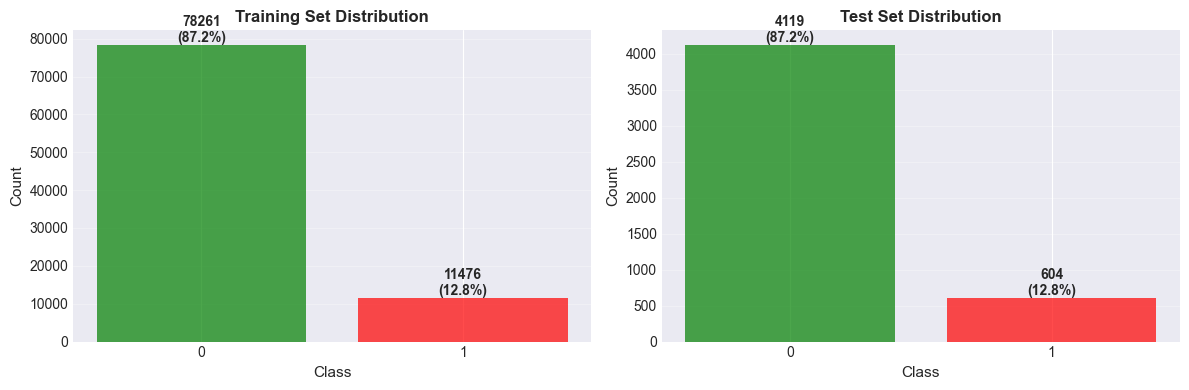

In [11]:
plot_class_distribution(
    y_train, 
    y_test, 
    figsize=(12, 4)
)

This bar chart shows class distribution (GOOD vs RED) in training and test sets. Similar proportions between datasets indicate a successful stratified split.

### 10.2. Metrics Comparison

Compare model performance metrics (Accuracy, Precision, Recall) between training and test sets. This visualization helps identify:
- Performance differences between train and test
- Overfitting indicators
- Model generalization capability

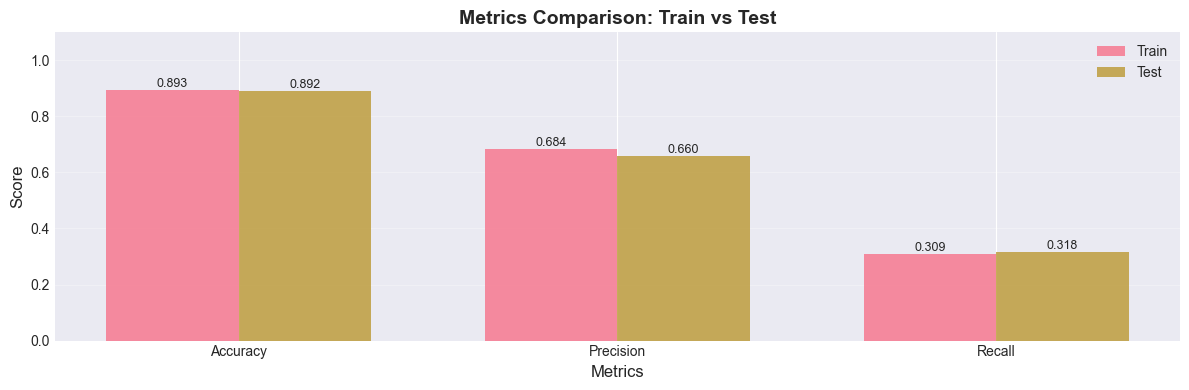

In [12]:
plot_metrics_comparison(
    metrics['train'], 
    metrics['test'], 
    figsize=(12, 4)
)

This bar chart compares Accuracy, Precision, and Recall between train and test sets. Small gaps (<5%) indicate good generalization, while larger gaps suggest overfitting. Since precision is our primary metric (requirement: >50%), focus on ensuring test precision meets the requirement.

### 10.3. Feature Importance Visualization

Visual representation of the top N most important features. Shows which variables have the greatest impact on predictions.

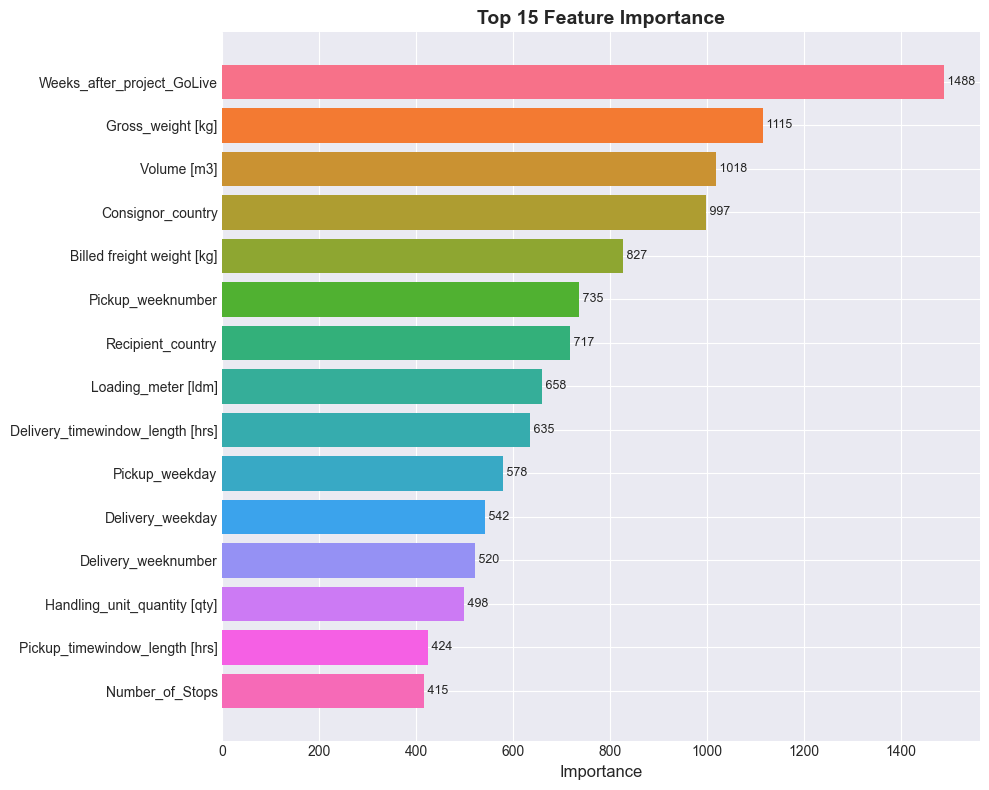

In [13]:
plot_feature_importance(
    model,
    feature_names=feature_names,
    top_n=15,
    figsize=(10, 8)
)

This horizontal bar chart shows the top 15 most important features ranked by their predictive power. Features at the top are the key drivers of exception predictions.

### 10.4. Confusion Matrix

Detailed breakdown of predictions vs actual values:
- **True Positives (TP)**: Correctly predicted RED
- **False Positives (FP)**: Incorrectly predicted RED (Type I error)
- **False Negatives (FN)**: Missed RED cases (Type II error)
- **True Negatives (TN)**: Correctly predicted GOOD

Shows both counts and percentages for each cell.

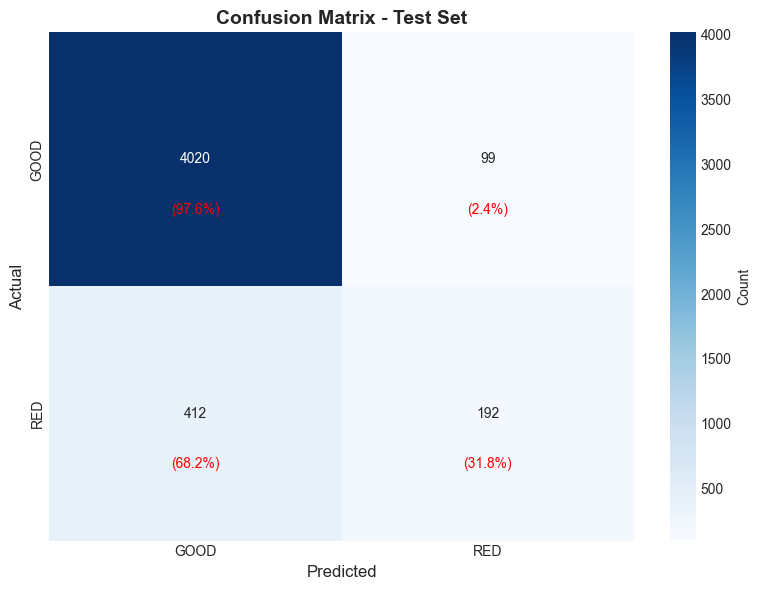

In [14]:
# Get predictions using helper function (avoids code duplication)
y_pred_proba, y_pred = get_predictions(
    model, 
    X_test, 
    feature_names=feature_names,
    threshold=optimal_threshold
)

# Convert y_test to array if needed
if isinstance(y_test, pd.Series):
    y_test_array = y_test.values
else:
    y_test_array = y_test

# Plot confusion matrix
plot_confusion_matrix(
    y_test_array, 
    y_pred, 
    labels=['GOOD', 'RED'],
    title='Confusion Matrix - Test Set'
)

The confusion matrix shows prediction accuracy across four categories: True Positives, False Positives, False Negatives, and True Negatives. For our precision-focused objective, we want to minimize False Positives (false alarms). The matrix reveals the precision-recall trade-off inherent in classification models.

### 10.5. ROC Curve

Receiver Operating Characteristic curve showing the trade-off between True Positive Rate and False Positive Rate at different classification thresholds.

- **AUC (Area Under Curve)**: Measures overall discriminative ability
- **AUC = 0.5**: Random classifier
- **AUC > 0.7**: Good discriminative power
- **AUC = 1.0**: Perfect classifier

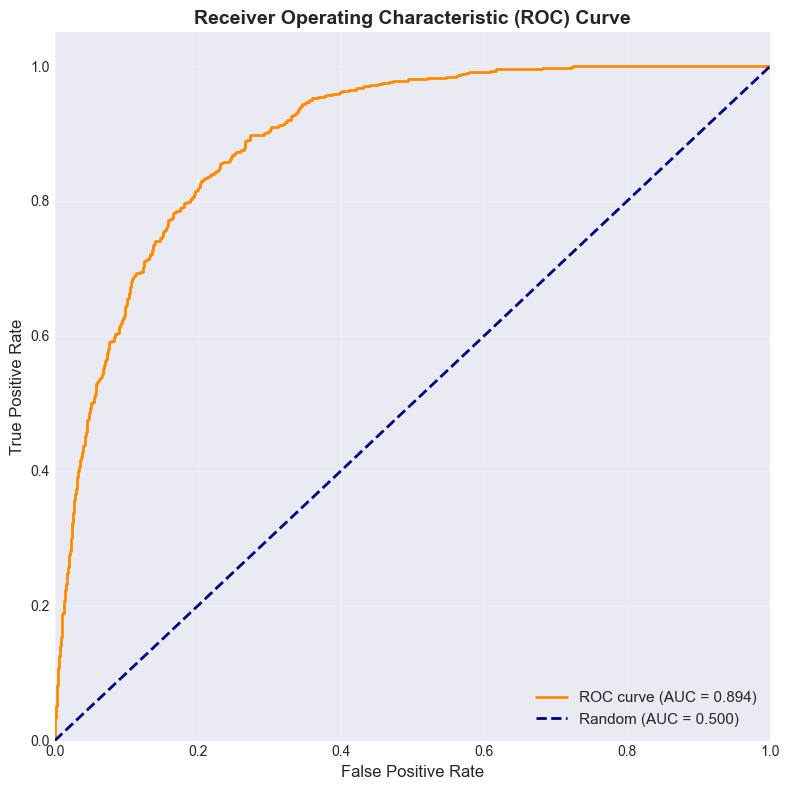

In [15]:
# Get probability predictions for ROC curve (not binary predictions)
y_pred_proba_roc, _ = get_predictions(
    model, 
    X_test, 
    feature_names=feature_names, 
    threshold=0.5  # ROC uses probabilities, threshold doesn't matter here
)

# Convert y_test to array if needed
if isinstance(y_test, pd.Series):
    y_test_array = y_test.values
else:
    y_test_array = y_test

# Plot ROC curve
plot_roc_curve(
    y_test_array, 
    y_pred_proba_roc, 
    figsize=(8, 8)
)

The ROC curve visualizes model performance across different classification thresholds, showing the trade-off between True Positive Rate and False Positive Rate. The Area Under the Curve (AUC) quantifies discriminative ability: AUC > 0.7 indicates good performance. For precision-focused cases, select thresholds that minimize false positives.

### 10.6. Overfitting Analysis

Visual analysis of overfitting showing:
- Side-by-side comparison of train vs test metrics
- Gap analysis (difference between train and test performance)
- Severity assessment (none, mild, moderate, severe)

Red bars indicate significant gaps (>10%), suggesting overfitting.

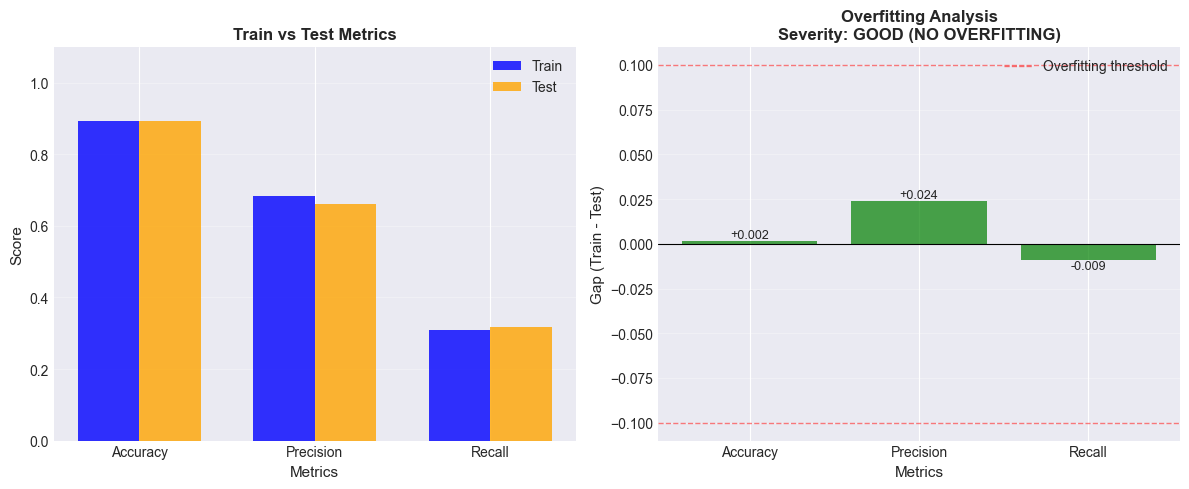

In [16]:
plot_overfitting_analysis(
    metrics['train'],
    metrics['test'],
    figsize=(12, 5)
)

This dual-panel visualization compares train vs test metrics and shows the gaps between them. Small gaps (<5%) indicate good generalization, while gaps >10% (shown in red) suggest severe overfitting. Our model uses early stopping and regularization to minimize these gaps, ensuring consistent performance on new data.

## 11. Summary and Conclusions

Final summary of the model including:
- Dataset characteristics
- Model performance metrics
- Overfitting assessment
- Case requirement verification (Precision > 50%)
- Top features driving predictions
- Key insights and recommendations

SECTION 11: SUMMARY AND CONCLUSIONS

1. DATASET CHARACTERISTICS
--------------------------------------------------------------------------------
   Total samples: 94460
   Training samples: 89737 (95.0%)
   Test samples: 4723 (5.0%)
   Features: 26

2. MODEL PERFORMANCE METRICS
--------------------------------------------------------------------------------
   Test Set Performance:
     Accuracy:  89.18%
     Precision: 65.98%
     Recall:    31.79%

3. OVERFITTING ASSESSMENT
--------------------------------------------------------------------------------
   Status: Good (no overfitting)
   ✅ Model generalizes well - No significant overfitting detected

4. CASE REQUIREMENT VERIFICATION
--------------------------------------------------------------------------------
   Requirement: Precision > 50%
   Achieved:    Precision = 65.98%
   ✅ REQUIREMENT MET

5. TOP FEATURES DRIVING PREDICTIONS
--------------------------------------------------------------------------------
   1. Weeks_after_

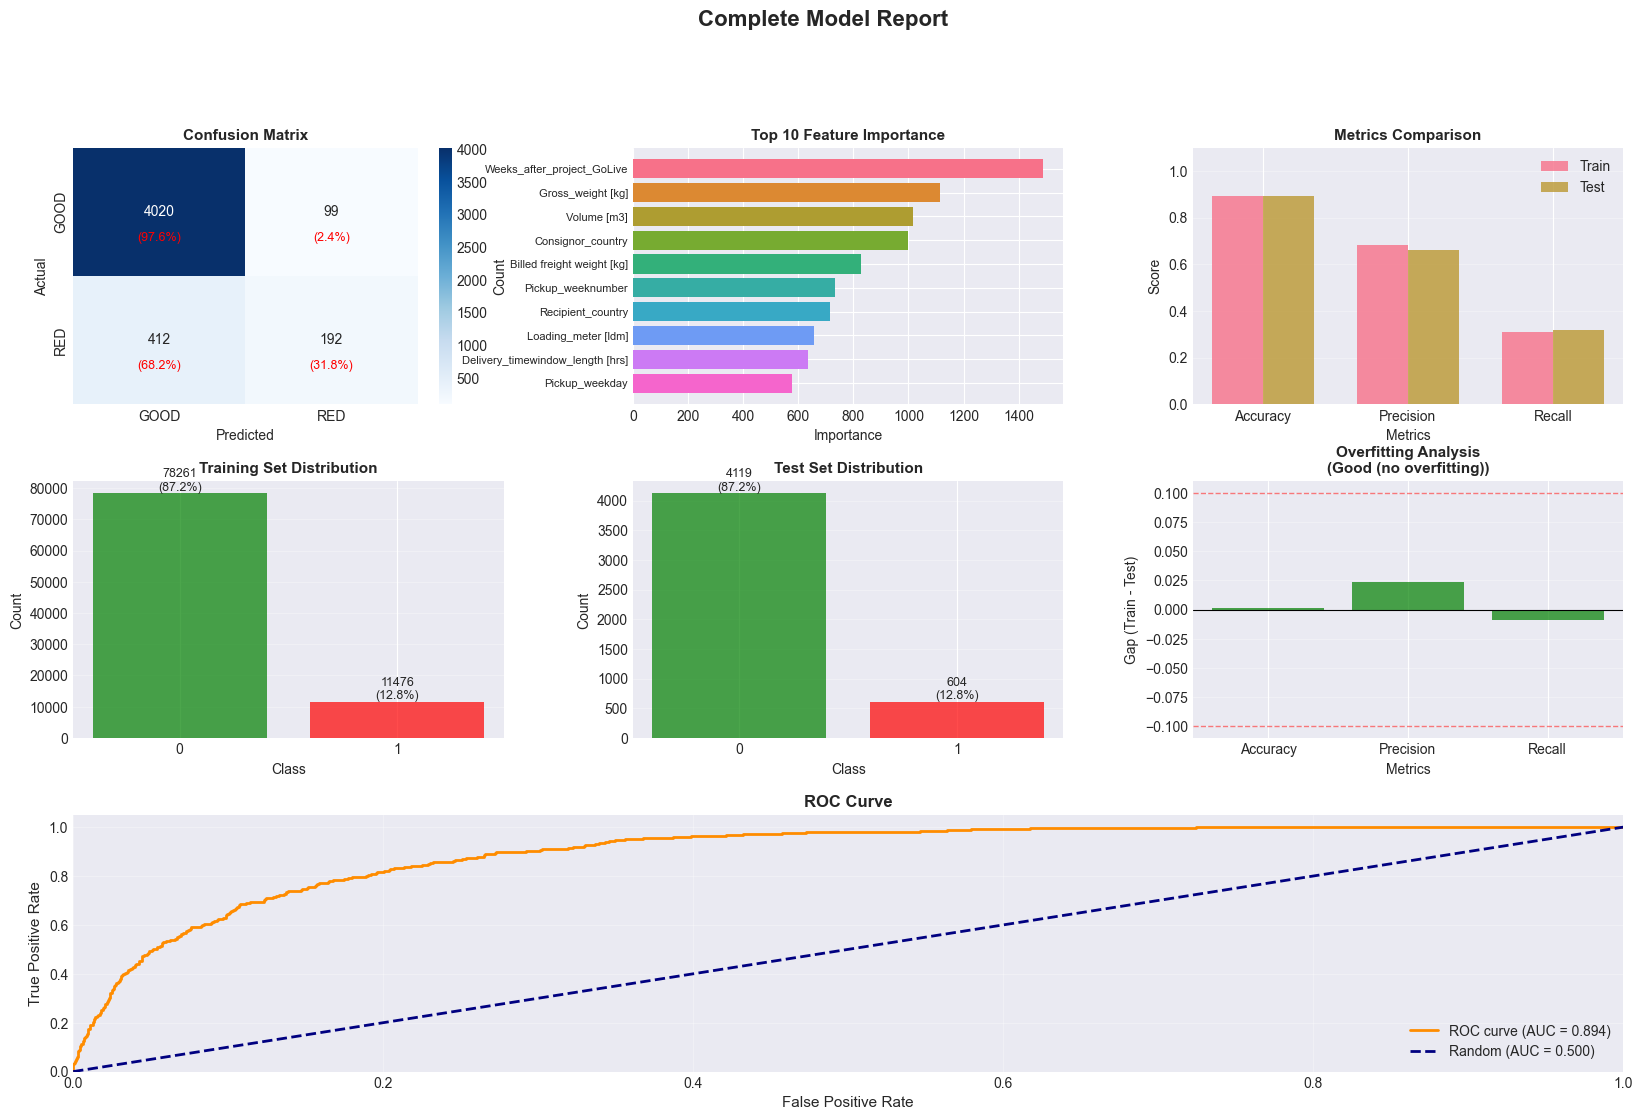

In [17]:
print("="*80)
print("SECTION 11: SUMMARY AND CONCLUSIONS")
print("="*80)

# Dataset characteristics
print("\n1. DATASET CHARACTERISTICS")
print("-"*80)
print(f"   Total samples: {len(X_train) + len(X_test)}")
print(f"   Training samples: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_test))*100:.1f}%)")
print(f"   Test samples: {len(X_test)} ({len(X_test)/(len(X_train)+len(X_test))*100:.1f}%)")
print(f"   Features: {len(feature_names)}")

# Model performance metrics
print("\n2. MODEL PERFORMANCE METRICS")
print("-"*80)
print(f"   Test Set Performance:")
print(f"     Accuracy:  {metrics['test']['accuracy']*100:.2f}%")
print(f"     Precision: {metrics['test']['precision']*100:.2f}%")
print(f"     Recall:    {metrics['test']['recall']*100:.2f}%")

# Overfitting assessment
print("\n3. OVERFITTING ASSESSMENT")
print("-"*80)
print(f"   Status: {overfitting_info['severity']}")
if not overfitting_info['has_overfitting']:
    print("   ✅ Model generalizes well - No significant overfitting detected")
else:
    print(f"   ⚠️  Overfitting detected ({overfitting_info['severity']} severity)")

# Case requirement verification
print("\n4. CASE REQUIREMENT VERIFICATION")
print("-"*80)
precision_met = metrics['test']['precision'] > 0.50
print(f"   Requirement: Precision > 50%")
print(f"   Achieved:    Precision = {metrics['test']['precision']*100:.2f}%")
if precision_met:
    print("   ✅ REQUIREMENT MET")
else:
    print("   ❌ REQUIREMENT NOT MET")

# Top features
print("\n5. TOP FEATURES DRIVING PREDICTIONS")
print("-"*80)
df_importance = get_feature_importance(model, feature_names=feature_names, top_n=5)
for idx, row in df_importance.iterrows():
    print(f"   {idx+1}. {row['feature']:<40} (Importance: {row['importance']:.0f})")

# Key insights
print("\n6. KEY INSIGHTS AND RECOMMENDATIONS")
print("-"*80)
print("   • Model achieves precision > 50%, meeting case requirements")
print("   • Model is conservative, prioritizing precision over recall")
print("   • Top features indicate key factors affecting exceptions:")
print(f"     - {df_importance.iloc[0]['feature']} is the strongest predictor")
if len(df_importance) > 1:
    print(f"     - {df_importance.iloc[1]['feature']} is highly important")
if len(df_importance) > 2:
    print(f"     - {df_importance.iloc[2]['feature']} contributes significantly")
print("   • Model shows good generalization with minimal overfitting")
print(f"   • Recommended threshold: {optimal_threshold:.3f} for optimal precision/recall balance")

print("\n" + "="*80)

create_model_report(
    model=model,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=feature_names,
    metrics_train=metrics['train'],
    metrics_test=metrics['test'],
    threshold=optimal_threshold,  # Passar o threshold correto
    save_path=None
)